In [1]:
%load_ext autoreload
import os,sys
import pandas as pd
import seaborn as sns
import numpy as np
import progressbar
import dill as pickle
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
sys.path.append("../")

print(sys.path)

%autoreload 2
from src.pySRM.pysrm.segment import IMZMLExtract, SpectraRegion, ProteinWeights, CombinedSpectra



['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/mjoppich/.local/lib/python3.6/site-packages', '/home/mjoppich/.local/lib/python3.6/site-packages/mpld3-0.3.1.dev1-py3.6.egg', '/home/mjoppich/.local/lib/python3.6/site-packages/opennre-0.1-py3.6.egg', '/usr/local/lib/python3.6/dist-packages', '/usr/local/lib/python3.6/dist-packages/tf_unet-0.1.1-py3.6.egg', '/mnt/d/PythonCGI/jupyter_micropython_kernel', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/home/mjoppich/.ipython', '../']


/usr/local/lib/python3.6/dist-packages/numba/core/errors.py:144: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1

In [2]:
imze = IMZMLExtract("/mnt/d/dev/data/msi/slideD/181114_AT1_Slide_D_Proteins.imzML")

Opening regions file for /mnt/d/dev/data/msi/slideD/181114_AT1_Slide_D_Proteins.imzML


0 ((356, 400, 215, 273), 2655)
1 ((436, 478, 632, 687), 2408)
2 ((1572, 1612, 608, 666), 2419)
3 ((1149, 1197, 142, 205), 3136)
4 ((618, 666, 211, 266), 2744)
5 ((633, 684, 630, 688), 3068)
6 ((1357, 1400, 628, 686), 2596)


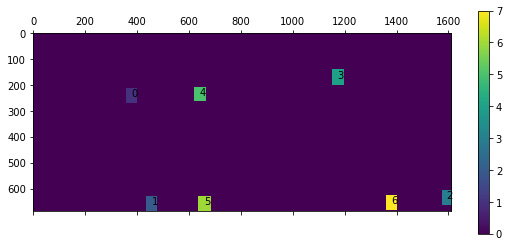

{0: ((356, 400, 215, 273), 2655),
 1: ((436, 478, 632, 687), 2408),
 2: ((1572, 1612, 608, 666), 2419),
 3: ((1149, 1197, 142, 205), 3136),
 4: ((618, 666, 211, 266), 2744),
 5: ((633, 684, 630, 688), 3068),
 6: ((1357, 1400, 628, 686), 2596)}

In [3]:
imze.list_regions()

In [ ]:
spectra_orig = imze.get_region_array(0, makeNullLine=True)
spectra_intra = imze.normalize_region_array(spectra_orig, normalize="intra_median")
spectra = imze.normalize_region_array(spectra_intra, normalize="inter_median")

In [ ]:
imze.list_highest_peaks(spectra, counter=True)

In [ ]:
spec = SpectraRegion(spectra, imze.mzValues)

In [ ]:
spec.calculate_similarity(mode="spectra_log")

In [ ]:
spec.segment(method="UMAP_DBSCAN", number_of_regions=15)

In [ ]:
mpl.rcParams['figure.figsize'] = (10,6)
spec.vis_umap(legend=False)
mpl.rcParams['figure.figsize'] = (6,4)

In [ ]:
spec.plot_segments()

In [ ]:
spec.filter_clusters(method='remove_singleton')
spec.filter_clusters(method='merge_background')
spec.filter_clusters(method='remove_islands')

In [ ]:
spec.plot_segments()

In [ ]:
spec.segment(method="WARD", number_of_regions=15)

In [ ]:
spec.plot_segments()

In [ ]:
spec.filter_clusters(method='remove_singleton')
spec.filter_clusters(method='merge_background')
spec.filter_clusters(method='remove_islands')

In [ ]:
spec.plot_segments()

A manual curation of the segmentation is still possible!

In [ ]:
spec.segmented[0:6,] = 0

In [ ]:
spec.plot_segments()

Consensus Analysis

In [ ]:
spec.consensus_spectra()

In [ ]:
spec.consensus_similarity()

In [ ]:
spec.plot_consensus_similarity()

In [ ]:
spec.plot_consensus_similarity(mode="spectra")

In [ ]:
#spec.plot_inter_consensus_similarity()

# Differential Analysis

In [ ]:
spec.mass_heatmap(14954, min_cut_off=0.0025)

In [ ]:
dfobj = spec.mass_dabest(14954)

In [ ]:
spec.mass_dabest(14954, background=11)

In [ ]:
spec.plot_segments(highlight=11)

In [ ]:
spec.plot_segments(highlight=[10,12])

In [ ]:
spec.plot_segments(highlight=12)

In [ ]:
spec.clear_de_results()

In [ ]:
pw = ProteinWeights("protein_weights.tsv")

In [ ]:
mgenes = spec.find_all_markers(pw, includeBackground=False,
                               replaceExisting=False,
                               outdirectory="./",
                               use_methods=["ttest", "rank"])

In [ ]:
mgenes_bg = spec.find_all_markers(pw, includeBackground=True, replaceExisting=False, use_methods = ["ttest", "rank"])

In [ ]:
spec.list_de_results()

In [ ]:
markerGenes = mgenes["ttest"]
markerGenes.to_csv("marker_genes.tsv", sep="\t", index=False)

In [ ]:
print("Number of unique, differentially detected proteins (from masses): {}".format(len(set(mgenes["ttest"]["gene"]))))

In [ ]:
markerGenesBG = mgenes_bg["ttest"]
markerGenesBG.to_csv("marker_genes_bg.tsv", sep="\t", index=False)

In [ ]:
print("Number of unique, differentially detected proteins (from masses): {}".format(len(set(mgenes_bg["ttest"]["gene"]))))

In [ ]:
with open("slideD_region_0.spec.pickle", "wb") as fout:
    pickle.dump(spec, fout)

In [ ]:
resClus8 = spec.find_de_results( (8,) )
resClus8

In [ ]:
deResDFs = spec.get_de_results( resClus8[1][1] )
deRes = spec.deres_to_df(deResDFs["ttest"], resClus8[1][1], pw)


In [ ]:
deRes.to_csv("region1_cluster8.tsv", sep="\t")

In [ ]:
set(markerGenes[(markerGenes["clusterID"] == "14") & (markerGenes["avg_logFC"] >0.01)]["gene"])

In [ ]:
for x in set(markerGenes[(markerGenes["clusterID"] == "8") & (markerGenes["avg_logFC"] >0.01)]["gene"]):
    print(x)

In [ ]:
spec.mass_heatmap(8566.308604)

In [ ]:
spec.mass_heatmap(6645.182024)

In [ ]:
import progressbar
import time

bar = progressbar.ProgressBar(widgets=[
        progressbar.Bar(), ' ', progressbar.Percentage(), ' ', 'AdaptiveETA: ', progressbar.AdaptiveETA()
    ])

for x in bar(range(0,10)):
    time.sleep(1)

In [ ]:
spec.mass_heatmap(14048.989568)

# Cell-type detection

Cell-type detection requires analyseMarkers.py from https://github.com/mjoppich/scrnaseq_celltype_prediction .

In [ ]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes.tsv -n 2

In [ ]:
spec.plot_segments(highlight=(8))

In [ ]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_bg.tsv -n 2

In [ ]:
spec.plot_segments(highlight=(8))

In [ ]:
spec.to_aorta3d("./slided_test/", "slided", 0, protWeights=pw, nodf=False, pathPrefix="../data/test_msi/")

In [ ]:
!ls slided_test

# Preparations for CombinedSpectra

In [ ]:
spectra1 = imze.get_region_array(1, makeNullLine=True)
imze.normalize_region_array(spectra1, normalize="vector")
imze.list_highest_peaks(spectra1, counter=True)
print("Got spectra", spectra1.shape)

spec1 = SpectraRegion(spectra1, imze.mzValues)
spec1.calculate_similarity(mode="spectra_log_dist")
spec1.segment(method="WARD", number_of_regions=15)
spec1.plot_segments()

In [4]:
pw = ProteinWeights("protein_weights.tsv")

def process_imzeregion(imze, regionID, basename):
    
    print("Processing regionID", regionID, "for basename", basename)
    
    spectra_orig = imze.get_region_array(regionID, makeNullLine=True)
    spectra_intra = imze.normalize_region_array(spectra_orig, normalize="intra_median")
    spectra = imze.normalize_region_array(spectra_intra, normalize="inter_median")
    
    rspec = SpectraRegion(spectra, imze.mzValues, name=basename + "_" + str(regionID))
    rspec.calculate_similarity(mode="spectra_log_dist")
    rspec.segment(method="WARD", number_of_regions=15)
    rspec.plot_segments()
    
    rspec.filter_clusters(method='remove_singleton')
    rspec.filter_clusters(method='merge_background')
    rspec.filter_clusters(method='remove_islands')
    rspec.plot_segments()
    
    rspec.consensus_spectra()
    rspec.consensus_similarity()
    rspec.plot_consensus_similarity()
    
    mgenes = rspec.find_all_markers(pw, includeBackground=False, replaceExisting=False, use_methods = ["ttest", "rank"])
    mgenes_bg = rspec.find_all_markers(pw, includeBackground=True, replaceExisting=False, use_methods = ["ttest", "rank"])
    
    return rspec, mgenes, mgenes_bg
    

Found region 0 with shape (45, 59, 17900)
I0710 18:58:07.637450 139724973016896 segment.py:2814] Found region 0 with shape (45, 59, 17900)


Processing regionID 0 for basename slideD


I0710 18:58:10.104134 139724973016896 segment.py:2528] Collecting fold changes
Got a total of 47524500 fold changes
I0710 18:58:47.880151 139724973016896 segment.py:2539] Got a total of 47524500 fold changes
Median elements [23762250]
I0710 18:58:50.190566 139724973016896 segment.py:2548] Median elements [23762250]
Median elements
I0710 18:58:51.196765 139724973016896 segment.py:2561] Median elements
Global Median 0.96164
I0710 18:58:51.198895 139724973016896 segment.py:2566] Global Median 0.96164
2020-07-10 18:58:52,983  SpectraRegion  INFO: Creating C++ obj
I0710 18:58:52.983646 139724973016896 segment.py:814] Creating C++ obj
2020-07-10 18:58:52,985  SpectraRegion  INFO: 17900 (45, 59, 17900)
I0710 18:58:52.985563 139724973016896 segment.py:815] 17900 (45, 59, 17900)
2020-07-10 18:58:52,987  SpectraRegion  INFO: dimensions 17900
I0710 18:58:52.987915 139724973016896 segment.py:825] dimensions 17900
2020-07-10 18:58:52,990  SpectraRegion  INFO: input dimensions (45, 59, 17900)
I0710 

17900


2020-07-10 18:58:53,275  SpectraRegion  INFO: Starting calc similarity c++
I0710 18:58:53.275200 139724973016896 segment.py:835] Starting calc similarity c++
2020-07-10 18:59:20,289  SpectraRegion  INFO: outclust dimensions (2655, 2655)
I0710 18:59:20.289792 139724973016896 segment.py:840] outclust dimensions (2655, 2655)
2020-07-10 18:59:20,312  SpectraRegion  INFO: Calculating spectra similarity
I0710 18:59:20.312503 139724973016896 segment.py:872] Calculating spectra similarity
2020-07-10 18:59:20,512  SpectraRegion  INFO: Calculating spectra similarity done
I0710 18:59:20.512777 139724973016896 segment.py:876] Calculating spectra similarity done
2020-07-10 18:59:20,514  SpectraRegion  INFO: Calculating dist pixel map
I0710 18:59:20.514858 139724973016896 segment.py:883] Calculating dist pixel map
2020-07-10 19:00:31,687  SpectraRegion  INFO: Calculating dist pixel map done
I0710 19:00:31.687308 139724973016896 segment.py:893] Calculating dist pixel map done
2020-07-10 19:00:31,856 

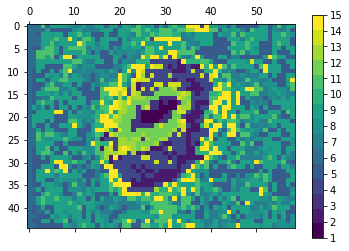

2020-07-10 19:00:32,500  SpectraRegion  INFO: Assigning clusters to background: {5, 6, 7, 8, 9, 11}
I0710 19:00:32.500578 139724973016896 segment.py:1219] Assigning clusters to background: {5, 6, 7, 8, 9, 11}


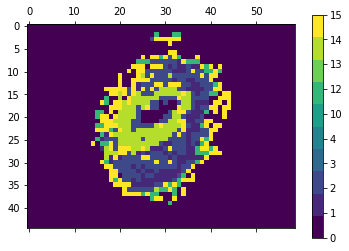

2020-07-10 19:00:32,714  SpectraRegion  INFO: Calculating consensus spectra
I0710 19:00:32.714046 139724973016896 segment.py:1273] Calculating consensus spectra
2020-07-10 19:00:32,762  SpectraRegion  INFO: Calculating consensus spectra done
I0710 19:00:32.762195 139724973016896 segment.py:1285] Calculating consensus spectra done


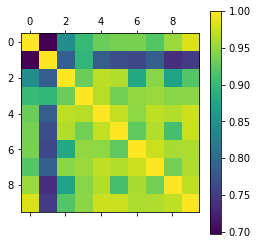

2020-07-10 19:00:33,006  SpectraRegion  INFO: DE data for case: [10]
I0710 19:00:33.006881 139724973016896 segment.py:1842] DE data for case: [10]
2020-07-10 19:00:33,008  SpectraRegion  INFO: DE data for control: [4, 15, 2, 14, 13, 12, 3, 1]
I0710 19:00:33.008739 139724973016896 segment.py:1843] DE data for control: [4, 15, 2, 14, 13, 12, 3, 1]
2020-07-10 19:00:33,010  SpectraRegion  INFO: DE result key: ((10,), (1, 2, 3, 4, 12, 13, 14, 15))
I0710 19:00:33.010778 139724973016896 segment.py:1847] DE result key: ((10,), (1, 2, 3, 4, 12, 13, 14, 15))


Running [10] against [4, 15, 2, 14, 13, 12, 3, 1]


2020-07-10 19:00:34,292  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 679)
I0710 19:00:34.292190 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 679)
2020-07-10 19:00:34,296  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (679, 3)
I0710 19:00:34.296871 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (679, 3)
2020-07-10 19:00:34,305  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:00:34.305966 139724973016896 segment.py:1957] Performing DE-test: ttest
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
2020-07-10 19:00:35,427  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((10,), (1, 2, 3, 4, 12, 13, 14, 15))
I0710 19:00:35.427097 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((10,), (1, 2, 3, 4, 12, 13, 14, 15))
2020-07-10 19:00

Running [4] against [10, 15, 2, 14, 13, 12, 3, 1]


2020-07-10 19:00:52,069  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 679)
I0710 19:00:52.069136 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 679)
2020-07-10 19:00:52,079  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (679, 3)
I0710 19:00:52.079886 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (679, 3)
2020-07-10 19:00:52,095  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:00:52.095556 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:00:53,303  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((4,), (1, 2, 3, 10, 12, 13, 14, 15))
I0710 19:00:53.303107 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((4,), (1, 2, 3, 10, 12, 13, 14, 15))
2020-07-10 19:00:53,305  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:00:53.305206 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:01:01,993  SpectraRegion  INFO: DE-test (rank) fini

Running [15] against [10, 4, 2, 14, 13, 12, 3, 1]


2020-07-10 19:01:05,267  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 679)
I0710 19:01:05.267461 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 679)
2020-07-10 19:01:05,271  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (679, 3)
I0710 19:01:05.271798 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (679, 3)
2020-07-10 19:01:05,279  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:01:05.279590 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:01:06,428  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((15,), (1, 2, 3, 4, 10, 12, 13, 14))
I0710 19:01:06.428442 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((15,), (1, 2, 3, 4, 10, 12, 13, 14))
2020-07-10 19:01:06,430  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:01:06.430154 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:01:15,085  SpectraRegion  INFO: DE-test (rank) fini

Running [2] against [10, 4, 15, 14, 13, 12, 3, 1]


2020-07-10 19:01:22,393  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 679)
I0710 19:01:22.393265 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 679)
2020-07-10 19:01:22,397  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (679, 3)
I0710 19:01:22.397828 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (679, 3)
2020-07-10 19:01:22,404  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:01:22.404836 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:01:23,519  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((2,), (1, 3, 4, 10, 12, 13, 14, 15))
I0710 19:01:23.519813 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((2,), (1, 3, 4, 10, 12, 13, 14, 15))
2020-07-10 19:01:23,521  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:01:23.521243 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:01:31,894  SpectraRegion  INFO: DE-test (rank) fini

Running [14] against [10, 4, 15, 2, 13, 12, 3, 1]


2020-07-10 19:01:37,625  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 679)
I0710 19:01:37.625143 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 679)
2020-07-10 19:01:37,630  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (679, 3)
I0710 19:01:37.630781 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (679, 3)
2020-07-10 19:01:37,643  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:01:37.643850 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:01:38,783  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((14,), (1, 2, 3, 4, 10, 12, 13, 15))
I0710 19:01:38.783921 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((14,), (1, 2, 3, 4, 10, 12, 13, 15))
2020-07-10 19:01:38,785  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:01:38.785328 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:01:47,021  SpectraRegion  INFO: DE-test (rank) fini

Running [13] against [10, 4, 15, 2, 14, 12, 3, 1]


2020-07-10 19:01:49,865  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 679)
I0710 19:01:49.865596 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 679)
2020-07-10 19:01:49,870  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (679, 3)
I0710 19:01:49.870507 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (679, 3)
2020-07-10 19:01:49,876  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:01:49.876590 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:01:50,982  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((13,), (1, 2, 3, 4, 10, 12, 14, 15))
I0710 19:01:50.982522 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((13,), (1, 2, 3, 4, 10, 12, 14, 15))
2020-07-10 19:01:50,984  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:01:50.984055 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:01:59,249  SpectraRegion  INFO: DE-test (rank) fini

Running [12] against [10, 4, 15, 2, 14, 13, 3, 1]


2020-07-10 19:02:02,182  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 679)
I0710 19:02:02.182631 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 679)
2020-07-10 19:02:02,189  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (679, 3)
I0710 19:02:02.189301 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (679, 3)
2020-07-10 19:02:02,195  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:02:02.195737 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:02:03,346  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((12,), (1, 2, 3, 4, 10, 13, 14, 15))
I0710 19:02:03.346042 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((12,), (1, 2, 3, 4, 10, 13, 14, 15))
2020-07-10 19:02:03,347  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:02:03.347572 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:02:12,124  SpectraRegion  INFO: DE-test (rank) fini

Running [3] against [10, 4, 15, 2, 14, 13, 12, 1]


2020-07-10 19:02:20,656  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 679)
I0710 19:02:20.656235 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 679)
2020-07-10 19:02:20,661  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (679, 3)
I0710 19:02:20.661095 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (679, 3)
2020-07-10 19:02:20,669  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:02:20.669447 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:02:21,952  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((3,), (1, 2, 4, 10, 12, 13, 14, 15))
I0710 19:02:21.952128 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((3,), (1, 2, 4, 10, 12, 13, 14, 15))
2020-07-10 19:02:21,954  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:02:21.954590 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:02:30,424  SpectraRegion  INFO: DE-test (rank) fini

Running [1] against [10, 4, 15, 2, 14, 13, 12, 3]


2020-07-10 19:02:39,214  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 679)
I0710 19:02:39.214023 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 679)
2020-07-10 19:02:39,218  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (679, 3)
I0710 19:02:39.218706 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (679, 3)
2020-07-10 19:02:39,225  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:02:39.225805 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:02:40,347  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((1,), (2, 3, 4, 10, 12, 13, 14, 15))
I0710 19:02:40.347722 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((1,), (2, 3, 4, 10, 12, 13, 14, 15))
2020-07-10 19:02:40,349  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:02:40.349649 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:02:49,685  SpectraRegion  INFO: DE-test (rank) fini

Running [0] against [10, 4, 15, 2, 14, 13, 12, 3, 1]


2020-07-10 19:03:24,841  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2655)
I0710 19:03:24.841142 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2655)
2020-07-10 19:03:24,847  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2655, 3)
I0710 19:03:24.847662 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2655, 3)
2020-07-10 19:03:24,855  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:03:24.855365 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:03:29,251  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((0,), (1, 2, 3, 4, 10, 12, 13, 14, 15))
I0710 19:03:29.251188 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((0,), (1, 2, 3, 4, 10, 12, 13, 14, 15))
2020-07-10 19:03:29,253  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:03:29.253361 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:03:49,147  SpectraRegion  INFO: DE-test (

Running [10] against [0, 4, 15, 2, 14, 13, 12, 3, 1]


2020-07-10 19:04:17,456  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2655)
I0710 19:04:17.456995 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2655)
2020-07-10 19:04:17,462  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2655, 3)
I0710 19:04:17.462240 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2655, 3)
2020-07-10 19:04:17,474  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:04:17.474755 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:04:21,973  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((10,), (0, 1, 2, 3, 4, 12, 13, 14, 15))
I0710 19:04:21.973839 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((10,), (0, 1, 2, 3, 4, 12, 13, 14, 15))
2020-07-10 19:04:21,976  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:04:21.976619 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:04:40,650  SpectraRegion  INFO: DE-test (

Running [4] against [0, 10, 15, 2, 14, 13, 12, 3, 1]


2020-07-10 19:04:59,756  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2655)
I0710 19:04:59.756923 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2655)
2020-07-10 19:04:59,762  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2655, 3)
I0710 19:04:59.762496 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2655, 3)
2020-07-10 19:04:59,773  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:04:59.773640 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:05:04,055  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((4,), (0, 1, 2, 3, 10, 12, 13, 14, 15))
I0710 19:05:04.055859 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((4,), (0, 1, 2, 3, 10, 12, 13, 14, 15))
2020-07-10 19:05:04,057  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:05:04.057964 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:05:22,677  SpectraRegion  INFO: DE-test (

Running [15] against [0, 10, 4, 2, 14, 13, 12, 3, 1]


2020-07-10 19:05:50,392  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2655)
I0710 19:05:50.392481 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2655)
2020-07-10 19:05:50,404  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2655, 3)
I0710 19:05:50.404354 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2655, 3)
2020-07-10 19:05:50,419  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:05:50.419790 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:05:54,902  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((15,), (0, 1, 2, 3, 4, 10, 12, 13, 14))
I0710 19:05:54.902940 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((15,), (0, 1, 2, 3, 4, 10, 12, 13, 14))
2020-07-10 19:05:54,904  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:05:54.904858 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:06:13,577  SpectraRegion  INFO: DE-test (

Running [2] against [0, 10, 4, 15, 14, 13, 12, 3, 1]


2020-07-10 19:06:30,829  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2655)
I0710 19:06:30.829540 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2655)
2020-07-10 19:06:30,838  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2655, 3)
I0710 19:06:30.838165 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2655, 3)
2020-07-10 19:06:30,850  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:06:30.850473 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:06:35,189  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((2,), (0, 1, 3, 4, 10, 12, 13, 14, 15))
I0710 19:06:35.189618 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((2,), (0, 1, 3, 4, 10, 12, 13, 14, 15))
2020-07-10 19:06:35,191  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:06:35.191471 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:06:54,173  SpectraRegion  INFO: DE-test (

Running [14] against [0, 10, 4, 15, 2, 13, 12, 3, 1]


2020-07-10 19:07:27,493  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2655)
I0710 19:07:27.493106 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2655)
2020-07-10 19:07:27,498  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2655, 3)
I0710 19:07:27.498923 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2655, 3)
2020-07-10 19:07:27,507  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:07:27.507976 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:07:31,861  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((14,), (0, 1, 2, 3, 4, 10, 12, 13, 15))
I0710 19:07:31.861377 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((14,), (0, 1, 2, 3, 4, 10, 12, 13, 15))
2020-07-10 19:07:31,863  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:07:31.863134 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:07:50,755  SpectraRegion  INFO: DE-test (

Running [13] against [0, 10, 4, 15, 2, 14, 12, 3, 1]


2020-07-10 19:08:14,997  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2655)
I0710 19:08:14.997823 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2655)
2020-07-10 19:08:15,004  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2655, 3)
I0710 19:08:15.004501 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2655, 3)
2020-07-10 19:08:15,015  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:08:15.015002 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:08:19,427  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((13,), (0, 1, 2, 3, 4, 10, 12, 14, 15))
I0710 19:08:19.427998 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((13,), (0, 1, 2, 3, 4, 10, 12, 14, 15))
2020-07-10 19:08:19,429  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:08:19.429471 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:08:38,687  SpectraRegion  INFO: DE-test (

Running [12] against [0, 10, 4, 15, 2, 14, 13, 3, 1]


2020-07-10 19:09:08,528  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2655)
I0710 19:09:08.528396 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2655)
2020-07-10 19:09:08,536  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2655, 3)
I0710 19:09:08.536542 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2655, 3)
2020-07-10 19:09:08,546  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:09:08.546699 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:09:13,183  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((12,), (0, 1, 2, 3, 4, 10, 13, 14, 15))
I0710 19:09:13.183966 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((12,), (0, 1, 2, 3, 4, 10, 13, 14, 15))
2020-07-10 19:09:13,186  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:09:13.186115 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:09:36,166  SpectraRegion  INFO: DE-test (

Running [3] against [0, 10, 4, 15, 2, 14, 13, 12, 1]


2020-07-10 19:10:10,228  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2655)
I0710 19:10:10.228748 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2655)
2020-07-10 19:10:10,235  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2655, 3)
I0710 19:10:10.235327 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2655, 3)
2020-07-10 19:10:10,245  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:10:10.245779 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:10:14,546  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((3,), (0, 1, 2, 4, 10, 12, 13, 14, 15))
I0710 19:10:14.546636 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((3,), (0, 1, 2, 4, 10, 12, 13, 14, 15))
2020-07-10 19:10:14,549  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:10:14.549041 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:10:35,643  SpectraRegion  INFO: DE-test (

Running [1] against [0, 10, 4, 15, 2, 14, 13, 12, 3]


2020-07-10 19:11:11,783  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2655)
I0710 19:11:11.783978 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2655)
2020-07-10 19:11:11,789  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2655, 3)
I0710 19:11:11.789548 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2655, 3)
2020-07-10 19:11:11,797  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:11:11.797250 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:11:16,208  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((1,), (0, 2, 3, 4, 10, 12, 13, 14, 15))
I0710 19:11:16.208448 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((1,), (0, 2, 3, 4, 10, 12, 13, 14, 15))
2020-07-10 19:11:16,211  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:11:16.211027 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:11:35,742  SpectraRegion  INFO: DE-test (

Processing regionID 1 for basename slideD


Found region 1 with shape (43, 56, 17900)
I0710 19:12:05.109765 139724973016896 segment.py:2814] Found region 1 with shape (43, 56, 17900)
I0710 19:12:07.439907 139724973016896 segment.py:2528] Collecting fold changes
Got a total of 43103200 fold changes
I0710 19:12:42.502429 139724973016896 segment.py:2539] Got a total of 43103200 fold changes
Median elements [21551600]
I0710 19:12:44.949062 139724973016896 segment.py:2548] Median elements [21551600]
Median elements
I0710 19:12:46.259959 139724973016896 segment.py:2561] Median elements
Global Median 0.97223
I0710 19:12:46.262140 139724973016896 segment.py:2566] Global Median 0.97223
2020-07-10 19:12:47,920  SpectraRegion  INFO: Creating C++ obj
I0710 19:12:47.920780 139724973016896 segment.py:814] Creating C++ obj
2020-07-10 19:12:47,922  SpectraRegion  INFO: 17900 (43, 56, 17900)
I0710 19:12:47.922629 139724973016896 segment.py:815] 17900 (43, 56, 17900)
2020-07-10 19:12:47,925  SpectraRegion  INFO: dimensions 17900
I0710 19:12:47.92

17900


2020-07-10 19:12:48,217  SpectraRegion  INFO: Starting calc similarity c++
I0710 19:12:48.217670 139724973016896 segment.py:835] Starting calc similarity c++
2020-07-10 19:13:11,974  SpectraRegion  INFO: outclust dimensions (2408, 2408)
I0710 19:13:11.974554 139724973016896 segment.py:840] outclust dimensions (2408, 2408)
2020-07-10 19:13:11,996  SpectraRegion  INFO: Calculating spectra similarity
I0710 19:13:11.996339 139724973016896 segment.py:872] Calculating spectra similarity
2020-07-10 19:13:12,084  SpectraRegion  INFO: Calculating spectra similarity done
I0710 19:13:12.084645 139724973016896 segment.py:876] Calculating spectra similarity done
2020-07-10 19:13:12,087  SpectraRegion  INFO: Calculating dist pixel map
I0710 19:13:12.087361 139724973016896 segment.py:883] Calculating dist pixel map
2020-07-10 19:14:02,432  SpectraRegion  INFO: Calculating dist pixel map done
I0710 19:14:02.432467 139724973016896 segment.py:893] Calculating dist pixel map done
2020-07-10 19:14:02,538 

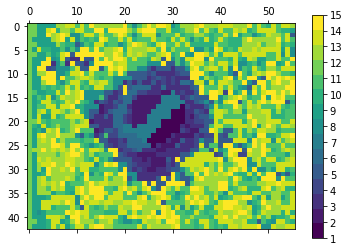

2020-07-10 19:14:03,043  SpectraRegion  INFO: Assigning clusters to background: {5, 8, 9, 10, 11, 12, 13, 14, 15}
I0710 19:14:03.043034 139724973016896 segment.py:1219] Assigning clusters to background: {5, 8, 9, 10, 11, 12, 13, 14, 15}


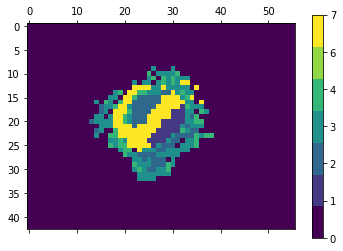

2020-07-10 19:14:03,223  SpectraRegion  INFO: Calculating consensus spectra
I0710 19:14:03.223954 139724973016896 segment.py:1273] Calculating consensus spectra
2020-07-10 19:14:03,441  SpectraRegion  INFO: Calculating consensus spectra done
I0710 19:14:03.441760 139724973016896 segment.py:1285] Calculating consensus spectra done


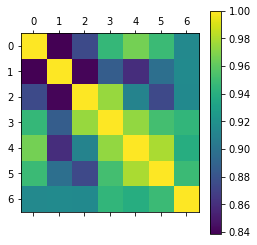

2020-07-10 19:14:03,693  SpectraRegion  INFO: DE data for case: [3]
I0710 19:14:03.693027 139724973016896 segment.py:1842] DE data for case: [3]
2020-07-10 19:14:03,694  SpectraRegion  INFO: DE data for control: [4, 6, 2, 7, 1]
I0710 19:14:03.694868 139724973016896 segment.py:1843] DE data for control: [4, 6, 2, 7, 1]
2020-07-10 19:14:03,696  SpectraRegion  INFO: DE result key: ((3,), (1, 2, 4, 6, 7))
I0710 19:14:03.696332 139724973016896 segment.py:1847] DE result key: ((3,), (1, 2, 4, 6, 7))


Running [3] against [4, 6, 2, 7, 1]


2020-07-10 19:14:04,082  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 343)
I0710 19:14:04.082149 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 343)
2020-07-10 19:14:04,086  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (343, 3)
I0710 19:14:04.086624 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (343, 3)
2020-07-10 19:14:04,095  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:14:04.095185 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:14:04,591  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((3,), (1, 2, 4, 6, 7))
I0710 19:14:04.591137 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((3,), (1, 2, 4, 6, 7))
2020-07-10 19:14:04,592  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:14:04.592944 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:14:11,127  SpectraRegion  INFO: DE-test (rank) finished. Results available: ((3

Running [4] against [3, 6, 2, 7, 1]


2020-07-10 19:14:12,592  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 343)
I0710 19:14:12.592257 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 343)
2020-07-10 19:14:12,596  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (343, 3)
I0710 19:14:12.596873 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (343, 3)
2020-07-10 19:14:12,605  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:14:12.605060 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:14:13,074  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((4,), (1, 2, 3, 6, 7))
I0710 19:14:13.074430 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((4,), (1, 2, 3, 6, 7))
2020-07-10 19:14:13,076  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:14:13.076256 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:14:19,820  SpectraRegion  INFO: DE-test (rank) finished. Results available: ((4

Running [6] against [3, 4, 2, 7, 1]


2020-07-10 19:14:21,220  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 343)
I0710 19:14:21.220787 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 343)
2020-07-10 19:14:21,227  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (343, 3)
I0710 19:14:21.227570 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (343, 3)
2020-07-10 19:14:21,239  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:14:21.239021 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:14:21,842  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((6,), (1, 2, 3, 4, 7))
I0710 19:14:21.842428 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((6,), (1, 2, 3, 4, 7))
2020-07-10 19:14:21,845  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:14:21.845072 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:14:28,721  SpectraRegion  INFO: DE-test (rank) finished. Results available: ((6

Running [2] against [3, 4, 6, 7, 1]


2020-07-10 19:14:35,927  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 343)
I0710 19:14:35.927991 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 343)
2020-07-10 19:14:35,937  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (343, 3)
I0710 19:14:35.937384 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (343, 3)
2020-07-10 19:14:35,953  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:14:35.953290 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:14:36,600  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((2,), (1, 3, 4, 6, 7))
I0710 19:14:36.600280 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((2,), (1, 3, 4, 6, 7))
2020-07-10 19:14:36,601  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:14:36.601818 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:14:44,577  SpectraRegion  INFO: DE-test (rank) finished. Results available: ((2

Running [7] against [3, 4, 6, 2, 1]


2020-07-10 19:14:50,491  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 343)
I0710 19:14:50.491984 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 343)
2020-07-10 19:14:50,498  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (343, 3)
I0710 19:14:50.498121 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (343, 3)
2020-07-10 19:14:50,510  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:14:50.510549 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:14:51,025  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((7,), (1, 2, 3, 4, 6))
I0710 19:14:51.025942 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((7,), (1, 2, 3, 4, 6))
2020-07-10 19:14:51,028  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:14:51.028158 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:14:57,961  SpectraRegion  INFO: DE-test (rank) finished. Results available: ((7

Running [1] against [3, 4, 6, 2, 7]


2020-07-10 19:15:03,897  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 343)
I0710 19:15:03.897971 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 343)
2020-07-10 19:15:03,904  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (343, 3)
I0710 19:15:03.904538 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (343, 3)
2020-07-10 19:15:03,912  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:15:03.912175 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:15:04,470  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((1,), (2, 3, 4, 6, 7))
I0710 19:15:04.470509 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((1,), (2, 3, 4, 6, 7))
2020-07-10 19:15:04,472  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:15:04.472131 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:15:11,335  SpectraRegion  INFO: DE-test (rank) finished. Results available: ((1

Running [0] against [3, 4, 6, 2, 7, 1]


2020-07-10 19:15:34,222  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2408)
I0710 19:15:34.222947 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2408)
2020-07-10 19:15:34,228  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2408, 3)
I0710 19:15:34.228905 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2408, 3)
2020-07-10 19:15:34,238  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:15:34.238717 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:15:38,457  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((0,), (1, 2, 3, 4, 6, 7))
I0710 19:15:38.457559 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((0,), (1, 2, 3, 4, 6, 7))
2020-07-10 19:15:38,459  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:15:38.459670 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:15:57,122  SpectraRegion  INFO: DE-test (rank) finished. Results avai

Running [3] against [0, 4, 6, 2, 7, 1]


2020-07-10 19:16:24,220  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2408)
I0710 19:16:24.220240 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2408)
2020-07-10 19:16:24,227  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2408, 3)
I0710 19:16:24.227009 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2408, 3)
2020-07-10 19:16:24,235  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:16:24.235928 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:16:28,395  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((3,), (0, 1, 2, 4, 6, 7))
I0710 19:16:28.395107 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((3,), (0, 1, 2, 4, 6, 7))
2020-07-10 19:16:28,397  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:16:28.397032 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:16:47,031  SpectraRegion  INFO: DE-test (rank) finished. Results avai

Running [4] against [0, 3, 6, 2, 7, 1]


2020-07-10 19:17:13,240  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2408)
I0710 19:17:13.240330 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2408)
2020-07-10 19:17:13,247  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2408, 3)
I0710 19:17:13.247940 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2408, 3)
2020-07-10 19:17:13,261  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:17:13.261778 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:17:17,417  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((4,), (0, 1, 2, 3, 6, 7))
I0710 19:17:17.417490 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((4,), (0, 1, 2, 3, 6, 7))
2020-07-10 19:17:17,419  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:17:17.419079 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:17:35,721  SpectraRegion  INFO: DE-test (rank) finished. Results avai

Running [6] against [0, 3, 4, 2, 7, 1]


2020-07-10 19:17:58,429  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2408)
I0710 19:17:58.429382 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2408)
2020-07-10 19:17:58,435  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2408, 3)
I0710 19:17:58.435022 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2408, 3)
2020-07-10 19:17:58,447  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:17:58.447668 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:18:02,636  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((6,), (0, 1, 2, 3, 4, 7))
I0710 19:18:02.636772 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((6,), (0, 1, 2, 3, 4, 7))
2020-07-10 19:18:02,639  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:18:02.639498 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:18:21,146  SpectraRegion  INFO: DE-test (rank) finished. Results avai

Running [2] against [0, 3, 4, 6, 7, 1]


2020-07-10 19:18:52,411  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2408)
I0710 19:18:52.411290 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2408)
2020-07-10 19:18:52,416  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2408, 3)
I0710 19:18:52.416550 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2408, 3)
2020-07-10 19:18:52,424  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:18:52.424825 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:18:56,342  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((2,), (0, 1, 3, 4, 6, 7))
I0710 19:18:56.342752 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((2,), (0, 1, 3, 4, 6, 7))
2020-07-10 19:18:56,344  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:18:56.344358 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:19:14,110  SpectraRegion  INFO: DE-test (rank) finished. Results avai

Running [7] against [0, 3, 4, 6, 2, 1]


2020-07-10 19:19:47,510  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2408)
I0710 19:19:47.510802 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2408)
2020-07-10 19:19:47,517  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2408, 3)
I0710 19:19:47.517257 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2408, 3)
2020-07-10 19:19:47,527  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:19:47.527158 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:19:51,477  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((7,), (0, 1, 2, 3, 4, 6))
I0710 19:19:51.477785 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((7,), (0, 1, 2, 3, 4, 6))
2020-07-10 19:19:51,479  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:19:51.479208 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:20:09,659  SpectraRegion  INFO: DE-test (rank) finished. Results avai

Running [1] against [0, 3, 4, 6, 2, 7]


2020-07-10 19:20:38,626  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2408)
I0710 19:20:38.626854 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2408)
2020-07-10 19:20:38,631  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2408, 3)
I0710 19:20:38.631916 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2408, 3)
2020-07-10 19:20:38,641  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:20:38.641494 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:20:42,910  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((1,), (0, 2, 3, 4, 6, 7))
I0710 19:20:42.910558 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((1,), (0, 2, 3, 4, 6, 7))
2020-07-10 19:20:42,912  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:20:42.912075 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:21:01,388  SpectraRegion  INFO: DE-test (rank) finished. Results avai

In [5]:
slided_0, slided0_mgenes, slided0_mgenes_bg = process_imzeregion(imze=imze, regionID= 0, basename="slideD")
slided_1, slided1_mgenes, slided1_mgenes_bg = process_imzeregion(imze=imze, regionID= 1, basename="slideD")

Processing regionID 4 for basename slideD


Found region 4 with shape (49, 56, 17900)
I0710 19:21:15.575461 139724973016896 segment.py:2814] Found region 4 with shape (49, 56, 17900)
I0710 19:21:18.714351 139724973016896 segment.py:2528] Collecting fold changes
Got a total of 49117600 fold changes
I0710 19:21:55.537350 139724973016896 segment.py:2539] Got a total of 49117600 fold changes
Median elements [24558800]
I0710 19:21:58.042391 139724973016896 segment.py:2548] Median elements [24558800]
Median elements
I0710 19:21:59.375652 139724973016896 segment.py:2561] Median elements
Global Median 0.97611
I0710 19:21:59.377367 139724973016896 segment.py:2566] Global Median 0.97611
2020-07-10 19:22:01,190  SpectraRegion  INFO: Creating C++ obj
I0710 19:22:01.190674 139724973016896 segment.py:814] Creating C++ obj
2020-07-10 19:22:01,192  SpectraRegion  INFO: 17900 (49, 56, 17900)
I0710 19:22:01.192745 139724973016896 segment.py:815] 17900 (49, 56, 17900)
2020-07-10 19:22:01,194  SpectraRegion  INFO: dimensions 17900
I0710 19:22:01.19

17900


2020-07-10 19:22:01,485  SpectraRegion  INFO: Starting calc similarity c++
I0710 19:22:01.485291 139724973016896 segment.py:835] Starting calc similarity c++
2020-07-10 19:22:31,376  SpectraRegion  INFO: outclust dimensions (2744, 2744)
I0710 19:22:31.376793 139724973016896 segment.py:840] outclust dimensions (2744, 2744)
2020-07-10 19:22:31,407  SpectraRegion  INFO: Calculating spectra similarity
I0710 19:22:31.407905 139724973016896 segment.py:872] Calculating spectra similarity
2020-07-10 19:22:31,595  SpectraRegion  INFO: Calculating spectra similarity done
I0710 19:22:31.595472 139724973016896 segment.py:876] Calculating spectra similarity done
2020-07-10 19:22:31,597  SpectraRegion  INFO: Calculating dist pixel map
I0710 19:22:31.597546 139724973016896 segment.py:883] Calculating dist pixel map
2020-07-10 19:23:36,757  SpectraRegion  INFO: Calculating dist pixel map done
I0710 19:23:36.757804 139724973016896 segment.py:893] Calculating dist pixel map done
2020-07-10 19:23:36,938 

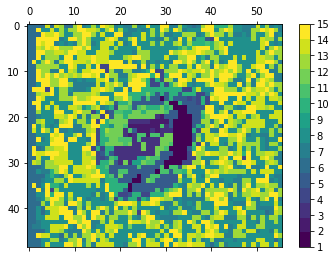

2020-07-10 19:23:37,618  SpectraRegion  INFO: Assigning clusters to background: {6, 7, 8, 13, 14, 15}
I0710 19:23:37.618025 139724973016896 segment.py:1219] Assigning clusters to background: {6, 7, 8, 13, 14, 15}


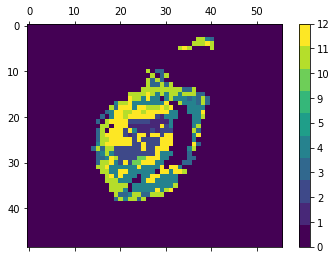

2020-07-10 19:23:37,806  SpectraRegion  INFO: Calculating consensus spectra
I0710 19:23:37.806702 139724973016896 segment.py:1273] Calculating consensus spectra
2020-07-10 19:23:37,887  SpectraRegion  INFO: Calculating consensus spectra done
I0710 19:23:37.887110 139724973016896 segment.py:1285] Calculating consensus spectra done


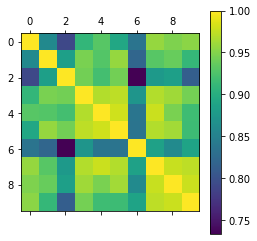

2020-07-10 19:23:38,145  SpectraRegion  INFO: DE data for case: [10]
I0710 19:23:38.145356 139724973016896 segment.py:1842] DE data for case: [10]
2020-07-10 19:23:38,146  SpectraRegion  INFO: DE data for control: [5, 4, 11, 12, 1, 3, 2, 9]
I0710 19:23:38.146836 139724973016896 segment.py:1843] DE data for control: [5, 4, 11, 12, 1, 3, 2, 9]
2020-07-10 19:23:38,149  SpectraRegion  INFO: DE result key: ((10,), (1, 2, 3, 4, 5, 9, 11, 12))
I0710 19:23:38.149149 139724973016896 segment.py:1847] DE result key: ((10,), (1, 2, 3, 4, 5, 9, 11, 12))


Running [10] against [5, 4, 11, 12, 1, 3, 2, 9]


2020-07-10 19:23:38,836  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 499)
I0710 19:23:38.836487 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 499)
2020-07-10 19:23:38,841  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (499, 3)
I0710 19:23:38.841446 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (499, 3)
2020-07-10 19:23:38,852  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:23:38.852379 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:23:39,586  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((10,), (1, 2, 3, 4, 5, 9, 11, 12))
I0710 19:23:39.586087 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((10,), (1, 2, 3, 4, 5, 9, 11, 12))
2020-07-10 19:23:39,587  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:23:39.587557 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:23:47,321  SpectraRegion  INFO: DE-test (rank) finished

Running [5] against [10, 4, 11, 12, 1, 3, 2, 9]


2020-07-10 19:23:50,801  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 499)
I0710 19:23:50.801824 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 499)
2020-07-10 19:23:50,805  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (499, 3)
I0710 19:23:50.805942 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (499, 3)
2020-07-10 19:23:50,816  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:23:50.816313 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:23:51,534  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((5,), (1, 2, 3, 4, 9, 10, 11, 12))
I0710 19:23:51.534751 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((5,), (1, 2, 3, 4, 9, 10, 11, 12))
2020-07-10 19:23:51,536  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:23:51.536095 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:23:59,053  SpectraRegion  INFO: DE-test (rank) finished

Running [4] against [10, 5, 11, 12, 1, 3, 2, 9]


2020-07-10 19:24:00,408  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 499)
I0710 19:24:00.408128 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 499)
2020-07-10 19:24:00,412  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (499, 3)
I0710 19:24:00.412745 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (499, 3)
2020-07-10 19:24:00,419  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:24:00.419678 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:24:01,166  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((4,), (1, 2, 3, 5, 9, 10, 11, 12))
I0710 19:24:01.166389 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((4,), (1, 2, 3, 5, 9, 10, 11, 12))
2020-07-10 19:24:01,168  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:24:01.168228 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:24:08,738  SpectraRegion  INFO: DE-test (rank) finished

Running [11] against [10, 5, 4, 12, 1, 3, 2, 9]


2020-07-10 19:24:15,607  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 499)
I0710 19:24:15.607038 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 499)
2020-07-10 19:24:15,612  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (499, 3)
I0710 19:24:15.612976 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (499, 3)
2020-07-10 19:24:15,622  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:24:15.622184 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:24:16,360  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((11,), (1, 2, 3, 4, 5, 9, 10, 12))
I0710 19:24:16.360751 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((11,), (1, 2, 3, 4, 5, 9, 10, 12))
2020-07-10 19:24:16,362  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:24:16.362974 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:24:24,174  SpectraRegion  INFO: DE-test (rank) finished

Running [12] against [10, 5, 4, 11, 1, 3, 2, 9]


2020-07-10 19:24:25,682  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 499)
I0710 19:24:25.682100 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 499)
2020-07-10 19:24:25,687  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (499, 3)
I0710 19:24:25.687673 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (499, 3)
2020-07-10 19:24:25,695  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:24:25.695751 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:24:26,452  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((12,), (1, 2, 3, 4, 5, 9, 10, 11))
I0710 19:24:26.452277 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((12,), (1, 2, 3, 4, 5, 9, 10, 11))
2020-07-10 19:24:26,453  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:24:26.453719 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:24:33,990  SpectraRegion  INFO: DE-test (rank) finished

Running [1] against [10, 5, 4, 11, 12, 3, 2, 9]


2020-07-10 19:24:44,351  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 499)
I0710 19:24:44.351114 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 499)
2020-07-10 19:24:44,358  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (499, 3)
I0710 19:24:44.358628 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (499, 3)
2020-07-10 19:24:44,372  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:24:44.372639 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:24:45,132  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((1,), (2, 3, 4, 5, 9, 10, 11, 12))
I0710 19:24:45.132264 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((1,), (2, 3, 4, 5, 9, 10, 11, 12))
2020-07-10 19:24:45,133  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:24:45.133886 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:24:53,022  SpectraRegion  INFO: DE-test (rank) finished

Running [3] against [10, 5, 4, 11, 12, 1, 2, 9]


2020-07-10 19:24:56,828  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 499)
I0710 19:24:56.828800 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 499)
2020-07-10 19:24:56,833  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (499, 3)
I0710 19:24:56.833566 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (499, 3)
2020-07-10 19:24:56,848  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:24:56.848258 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:24:57,626  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((3,), (1, 2, 4, 5, 9, 10, 11, 12))
I0710 19:24:57.626399 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((3,), (1, 2, 4, 5, 9, 10, 11, 12))
2020-07-10 19:24:57,627  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:24:57.627956 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:25:05,133  SpectraRegion  INFO: DE-test (rank) finished

Running [2] against [10, 5, 4, 11, 12, 1, 3, 9]


2020-07-10 19:25:10,508  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 499)
I0710 19:25:10.508017 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 499)
2020-07-10 19:25:10,512  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (499, 3)
I0710 19:25:10.512542 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (499, 3)
2020-07-10 19:25:10,519  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:25:10.519281 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:25:11,278  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((2,), (1, 3, 4, 5, 9, 10, 11, 12))
I0710 19:25:11.278596 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((2,), (1, 3, 4, 5, 9, 10, 11, 12))
2020-07-10 19:25:11,280  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:25:11.280006 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:25:18,686  SpectraRegion  INFO: DE-test (rank) finished

Running [9] against [10, 5, 4, 11, 12, 1, 3, 2]


2020-07-10 19:25:32,028  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 499)
I0710 19:25:32.028630 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 499)
2020-07-10 19:25:32,033  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (499, 3)
I0710 19:25:32.033470 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (499, 3)
2020-07-10 19:25:32,040  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:25:32.040497 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:25:32,827  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((9,), (1, 2, 3, 4, 5, 10, 11, 12))
I0710 19:25:32.827208 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((9,), (1, 2, 3, 4, 5, 10, 11, 12))
2020-07-10 19:25:32,829  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:25:32.829581 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:25:40,535  SpectraRegion  INFO: DE-test (rank) finished

Running [0] against [10, 5, 4, 11, 12, 1, 3, 2, 9]


2020-07-10 19:25:59,000  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2744)
I0710 19:25:59.000332 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2744)
2020-07-10 19:25:59,007  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2744, 3)
I0710 19:25:59.007661 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2744, 3)
2020-07-10 19:25:59,016  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:25:59.016276 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:26:03,584  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((0,), (1, 2, 3, 4, 5, 9, 10, 11, 12))
I0710 19:26:03.584765 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((0,), (1, 2, 3, 4, 5, 9, 10, 11, 12))
2020-07-10 19:26:03,586  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:26:03.586293 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:26:23,354  SpectraRegion  INFO: DE-test (rank

Running [10] against [0, 5, 4, 11, 12, 1, 3, 2, 9]


2020-07-10 19:26:55,547  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2744)
I0710 19:26:55.547613 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2744)
2020-07-10 19:26:55,553  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2744, 3)
I0710 19:26:55.553937 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2744, 3)
2020-07-10 19:26:55,562  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:26:55.562253 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:26:59,572  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((10,), (0, 1, 2, 3, 4, 5, 9, 11, 12))
I0710 19:26:59.572830 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((10,), (0, 1, 2, 3, 4, 5, 9, 11, 12))
2020-07-10 19:26:59,575  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:26:59.575386 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:27:18,653  SpectraRegion  INFO: DE-test (rank

Running [5] against [0, 10, 4, 11, 12, 1, 3, 2, 9]


2020-07-10 19:27:39,254  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2744)
I0710 19:27:39.254220 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2744)
2020-07-10 19:27:39,260  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2744, 3)
I0710 19:27:39.260565 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2744, 3)
2020-07-10 19:27:39,267  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:27:39.267640 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:27:43,558  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((5,), (0, 1, 2, 3, 4, 9, 10, 11, 12))
I0710 19:27:43.558874 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((5,), (0, 1, 2, 3, 4, 9, 10, 11, 12))
2020-07-10 19:27:43,561  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:27:43.561052 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:28:02,638  SpectraRegion  INFO: DE-test (rank

Running [4] against [0, 10, 5, 11, 12, 1, 3, 2, 9]


2020-07-10 19:28:35,513  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2744)
I0710 19:28:35.513536 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2744)
2020-07-10 19:28:35,519  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2744, 3)
I0710 19:28:35.519257 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2744, 3)
2020-07-10 19:28:35,529  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:28:35.529496 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:28:39,650  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((4,), (0, 1, 2, 3, 5, 9, 10, 11, 12))
I0710 19:28:39.650763 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((4,), (0, 1, 2, 3, 5, 9, 10, 11, 12))
2020-07-10 19:28:39,653  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:28:39.653457 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:28:58,801  SpectraRegion  INFO: DE-test (rank

Running [11] against [0, 10, 5, 4, 12, 1, 3, 2, 9]


2020-07-10 19:29:19,431  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2744)
I0710 19:29:19.431686 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2744)
2020-07-10 19:29:19,437  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2744, 3)
I0710 19:29:19.437622 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2744, 3)
2020-07-10 19:29:19,446  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:29:19.446871 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:29:23,758  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((11,), (0, 1, 2, 3, 4, 5, 9, 10, 12))
I0710 19:29:23.758531 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((11,), (0, 1, 2, 3, 4, 5, 9, 10, 12))
2020-07-10 19:29:23,760  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:29:23.760102 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:29:43,056  SpectraRegion  INFO: DE-test (rank

Running [12] against [0, 10, 5, 4, 11, 1, 3, 2, 9]


2020-07-10 19:30:13,156  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2744)
I0710 19:30:13.156439 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2744)
2020-07-10 19:30:13,161  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2744, 3)
I0710 19:30:13.161477 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2744, 3)
2020-07-10 19:30:13,171  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:30:13.171746 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:30:17,360  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((12,), (0, 1, 2, 3, 4, 5, 9, 10, 11))
I0710 19:30:17.360481 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((12,), (0, 1, 2, 3, 4, 5, 9, 10, 11))
2020-07-10 19:30:17,362  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:30:17.362340 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:30:36,473  SpectraRegion  INFO: DE-test (rank

Running [1] against [0, 10, 5, 4, 11, 12, 3, 2, 9]


2020-07-10 19:31:16,121  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2744)
I0710 19:31:16.121393 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2744)
2020-07-10 19:31:16,130  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2744, 3)
I0710 19:31:16.130881 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2744, 3)
2020-07-10 19:31:16,143  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:31:16.143730 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:31:21,898  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((1,), (0, 2, 3, 4, 5, 9, 10, 11, 12))
I0710 19:31:21.898904 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((1,), (0, 2, 3, 4, 5, 9, 10, 11, 12))
2020-07-10 19:31:21,901  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:31:21.901652 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:31:47,655  SpectraRegion  INFO: DE-test (rank

Running [3] against [0, 10, 5, 4, 11, 12, 1, 2, 9]


2020-07-10 19:32:44,133  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2744)
I0710 19:32:44.133798 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2744)
2020-07-10 19:32:44,139  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2744, 3)
I0710 19:32:44.139799 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2744, 3)
2020-07-10 19:32:44,152  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:32:44.152089 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:32:48,922  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((3,), (0, 1, 2, 4, 5, 9, 10, 11, 12))
I0710 19:32:48.922568 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((3,), (0, 1, 2, 4, 5, 9, 10, 11, 12))
2020-07-10 19:32:48,925  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:32:48.925846 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:33:10,627  SpectraRegion  INFO: DE-test (rank

Running [2] against [0, 10, 5, 4, 11, 12, 1, 3, 9]


2020-07-10 19:33:41,055  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2744)
I0710 19:33:41.055051 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2744)
2020-07-10 19:33:41,060  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2744, 3)
I0710 19:33:41.060169 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2744, 3)
2020-07-10 19:33:41,068  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:33:41.068214 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:33:44,781  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((2,), (0, 1, 3, 4, 5, 9, 10, 11, 12))
I0710 19:33:44.781584 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((2,), (0, 1, 3, 4, 5, 9, 10, 11, 12))
2020-07-10 19:33:44,782  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:33:44.782989 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:34:04,151  SpectraRegion  INFO: DE-test (rank

Running [9] against [0, 10, 5, 4, 11, 12, 1, 3, 2]


2020-07-10 19:34:48,891  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 2744)
I0710 19:34:48.891656 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 2744)
2020-07-10 19:34:48,897  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (2744, 3)
I0710 19:34:48.897657 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (2744, 3)
2020-07-10 19:34:48,906  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:34:48.906138 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:34:53,251  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((9,), (0, 1, 2, 3, 4, 5, 10, 11, 12))
I0710 19:34:53.251574 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((9,), (0, 1, 2, 3, 4, 5, 10, 11, 12))
2020-07-10 19:34:53,253  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:34:53.253565 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:35:12,098  SpectraRegion  INFO: DE-test (rank

Processing regionID 5 for basename slideD


Found region 5 with shape (52, 59, 17900)
I0710 19:35:16.030406 139724973016896 segment.py:2814] Found region 5 with shape (52, 59, 17900)
I0710 19:35:19.444126 139724973016896 segment.py:2528] Collecting fold changes
Got a total of 54917200 fold changes
I0710 19:36:01.327564 139724973016896 segment.py:2539] Got a total of 54917200 fold changes
Median elements [27458600]
I0710 19:36:04.179514 139724973016896 segment.py:2548] Median elements [27458600]
Median elements
I0710 19:36:05.538952 139724973016896 segment.py:2561] Median elements
Global Median 0.98204
I0710 19:36:05.540335 139724973016896 segment.py:2566] Global Median 0.98204
2020-07-10 19:36:07,552  SpectraRegion  INFO: Creating C++ obj
I0710 19:36:07.552772 139724973016896 segment.py:814] Creating C++ obj
2020-07-10 19:36:07,554  SpectraRegion  INFO: 17900 (52, 59, 17900)
I0710 19:36:07.554177 139724973016896 segment.py:815] 17900 (52, 59, 17900)
2020-07-10 19:36:07,556  SpectraRegion  INFO: dimensions 17900
I0710 19:36:07.55

17900


2020-07-10 19:36:07,879  SpectraRegion  INFO: Starting calc similarity c++
I0710 19:36:07.879904 139724973016896 segment.py:835] Starting calc similarity c++
2020-07-10 19:36:43,178  SpectraRegion  INFO: outclust dimensions (3068, 3068)
I0710 19:36:43.178151 139724973016896 segment.py:840] outclust dimensions (3068, 3068)
2020-07-10 19:36:43,206  SpectraRegion  INFO: Calculating spectra similarity
I0710 19:36:43.206114 139724973016896 segment.py:872] Calculating spectra similarity
2020-07-10 19:36:43,290  SpectraRegion  INFO: Calculating spectra similarity done
I0710 19:36:43.290369 139724973016896 segment.py:876] Calculating spectra similarity done
2020-07-10 19:36:43,296  SpectraRegion  INFO: Calculating dist pixel map
I0710 19:36:43.296717 139724973016896 segment.py:883] Calculating dist pixel map
2020-07-10 19:38:01,406  SpectraRegion  INFO: Calculating dist pixel map done
I0710 19:38:01.406160 139724973016896 segment.py:893] Calculating dist pixel map done
2020-07-10 19:38:01,475 

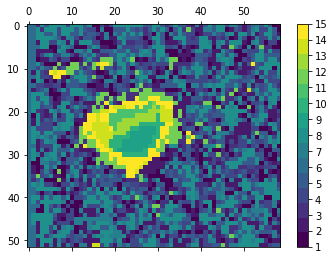

2020-07-10 19:38:02,106  SpectraRegion  INFO: Assigning clusters to background: {1, 2, 3, 4, 5, 6, 7, 8}
I0710 19:38:02.106771 139724973016896 segment.py:1219] Assigning clusters to background: {1, 2, 3, 4, 5, 6, 7, 8}


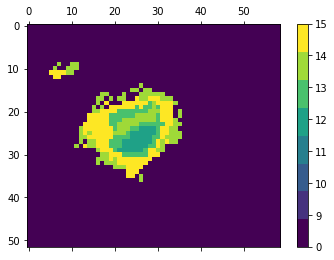

2020-07-10 19:38:02,283  SpectraRegion  INFO: Calculating consensus spectra
I0710 19:38:02.283089 139724973016896 segment.py:1273] Calculating consensus spectra
2020-07-10 19:38:02,335  SpectraRegion  INFO: Calculating consensus spectra done
I0710 19:38:02.335237 139724973016896 segment.py:1285] Calculating consensus spectra done


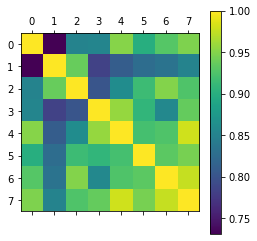

2020-07-10 19:38:02,586  SpectraRegion  INFO: DE data for case: [12]
I0710 19:38:02.586692 139724973016896 segment.py:1842] DE data for case: [12]
2020-07-10 19:38:02,589  SpectraRegion  INFO: DE data for control: [15, 14, 11, 13, 10, 9]
I0710 19:38:02.589075 139724973016896 segment.py:1843] DE data for control: [15, 14, 11, 13, 10, 9]
2020-07-10 19:38:02,591  SpectraRegion  INFO: DE result key: ((12,), (9, 10, 11, 13, 14, 15))
I0710 19:38:02.591388 139724973016896 segment.py:1847] DE result key: ((12,), (9, 10, 11, 13, 14, 15))


Running [12] against [15, 14, 11, 13, 10, 9]


2020-07-10 19:38:02,855  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 341)
I0710 19:38:02.855119 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 341)
2020-07-10 19:38:02,859  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (341, 3)
I0710 19:38:02.859832 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (341, 3)
2020-07-10 19:38:02,866  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:38:02.866565 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:38:03,150  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((12,), (9, 10, 11, 13, 14, 15))
I0710 19:38:03.150112 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((12,), (9, 10, 11, 13, 14, 15))
2020-07-10 19:38:03,151  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:38:03.151399 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:38:09,695  SpectraRegion  INFO: DE-test (rank) finished. Resu

Running [15] against [12, 14, 11, 13, 10, 9]


2020-07-10 19:38:14,621  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 341)
I0710 19:38:14.621128 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 341)
2020-07-10 19:38:14,625  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (341, 3)
I0710 19:38:14.625103 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (341, 3)
2020-07-10 19:38:14,632  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:38:14.632958 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:38:14,917  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((15,), (9, 10, 11, 12, 13, 14))
I0710 19:38:14.917707 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((15,), (9, 10, 11, 12, 13, 14))
2020-07-10 19:38:14,919  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:38:14.919134 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:38:21,409  SpectraRegion  INFO: DE-test (rank) finished. Resu

Running [14] against [12, 15, 11, 13, 10, 9]


2020-07-10 19:38:21,955  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 341)
I0710 19:38:21.955563 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 341)
2020-07-10 19:38:21,960  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (341, 3)
I0710 19:38:21.960917 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (341, 3)
2020-07-10 19:38:21,969  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:38:21.969095 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:38:22,247  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((14,), (9, 10, 11, 12, 13, 15))
I0710 19:38:22.247977 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((14,), (9, 10, 11, 12, 13, 15))
2020-07-10 19:38:22,249  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:38:22.249332 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:38:28,719  SpectraRegion  INFO: DE-test (rank) finished. Resu

Running [11] against [12, 15, 14, 13, 10, 9]


2020-07-10 19:38:33,981  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 341)
I0710 19:38:33.981726 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 341)
2020-07-10 19:38:33,986  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (341, 3)
I0710 19:38:33.986432 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (341, 3)
2020-07-10 19:38:33,992  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:38:33.992973 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:38:34,275  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((11,), (9, 10, 12, 13, 14, 15))
I0710 19:38:34.275221 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((11,), (9, 10, 12, 13, 14, 15))
2020-07-10 19:38:34,277  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:38:34.277215 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:38:40,897  SpectraRegion  INFO: DE-test (rank) finished. Resu

Running [13] against [12, 15, 14, 11, 10, 9]


2020-07-10 19:38:53,976  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 341)
I0710 19:38:53.976966 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 341)
2020-07-10 19:38:53,982  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (341, 3)
I0710 19:38:53.982027 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (341, 3)
2020-07-10 19:38:53,989  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:38:53.989801 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:38:54,272  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((13,), (9, 10, 11, 12, 14, 15))
I0710 19:38:54.272824 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((13,), (9, 10, 11, 12, 14, 15))
2020-07-10 19:38:54,274  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:38:54.274765 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:39:00,842  SpectraRegion  INFO: DE-test (rank) finished. Resu

Running [10] against [12, 15, 14, 11, 13, 9]


2020-07-10 19:39:08,783  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 341)
I0710 19:39:08.783707 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 341)
2020-07-10 19:39:08,790  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (341, 3)
I0710 19:39:08.790987 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (341, 3)
2020-07-10 19:39:08,802  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:39:08.802238 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:39:09,109  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((10,), (9, 11, 12, 13, 14, 15))
I0710 19:39:09.109103 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((10,), (9, 11, 12, 13, 14, 15))
2020-07-10 19:39:09,110  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:39:09.110500 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:39:15,712  SpectraRegion  INFO: DE-test (rank) finished. Resu

Running [9] against [12, 15, 14, 11, 13, 10]


2020-07-10 19:39:22,950  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 341)
I0710 19:39:22.950576 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 341)
2020-07-10 19:39:22,955  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (341, 3)
I0710 19:39:22.955066 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (341, 3)
2020-07-10 19:39:22,963  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:39:22.963067 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:39:23,202  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((9,), (10, 11, 12, 13, 14, 15))
I0710 19:39:23.202058 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((9,), (10, 11, 12, 13, 14, 15))
2020-07-10 19:39:23,203  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:39:23.203319 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:39:29,765  SpectraRegion  INFO: DE-test (rank) finished. Resu

Running [0] against [12, 15, 14, 11, 13, 10, 9]


2020-07-10 19:40:03,189  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 3068)
I0710 19:40:03.189916 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 3068)
2020-07-10 19:40:03,194  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (3068, 3)
I0710 19:40:03.194784 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (3068, 3)
2020-07-10 19:40:03,204  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:40:03.204388 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:40:08,445  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((0,), (9, 10, 11, 12, 13, 14, 15))
I0710 19:40:08.445296 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((0,), (9, 10, 11, 12, 13, 14, 15))
2020-07-10 19:40:08,446  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:40:08.446782 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:40:29,314  SpectraRegion  INFO: DE-test (rank) fini

Running [12] against [0, 15, 14, 11, 13, 10, 9]


2020-07-10 19:40:56,842  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 3068)
I0710 19:40:56.842841 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 3068)
2020-07-10 19:40:56,848  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (3068, 3)
I0710 19:40:56.848723 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (3068, 3)
2020-07-10 19:40:56,858  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:40:56.858350 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:41:01,702  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((12,), (0, 9, 10, 11, 13, 14, 15))
I0710 19:41:01.702031 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((12,), (0, 9, 10, 11, 13, 14, 15))
2020-07-10 19:41:01,703  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:41:01.703479 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:41:22,464  SpectraRegion  INFO: DE-test (rank) fini

Running [15] against [0, 12, 14, 11, 13, 10, 9]


2020-07-10 19:41:46,010  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 3068)
I0710 19:41:46.010990 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 3068)
2020-07-10 19:41:46,016  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (3068, 3)
I0710 19:41:46.016816 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (3068, 3)
2020-07-10 19:41:46,025  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:41:46.025832 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:41:50,865  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((15,), (0, 9, 10, 11, 12, 13, 14))
I0710 19:41:50.865653 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((15,), (0, 9, 10, 11, 12, 13, 14))
2020-07-10 19:41:50,867  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:41:50.867201 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:42:11,850  SpectraRegion  INFO: DE-test (rank) fini

Running [14] against [0, 12, 15, 11, 13, 10, 9]


2020-07-10 19:42:38,981  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 3068)
I0710 19:42:38.981309 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 3068)
2020-07-10 19:42:38,987  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (3068, 3)
I0710 19:42:38.987677 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (3068, 3)
2020-07-10 19:42:38,994  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:42:38.994750 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:42:43,835  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((14,), (0, 9, 10, 11, 12, 13, 15))
I0710 19:42:43.835665 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((14,), (0, 9, 10, 11, 12, 13, 15))
2020-07-10 19:42:43,837  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:42:43.837213 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:43:04,713  SpectraRegion  INFO: DE-test (rank) fini

Running [11] against [0, 12, 15, 14, 13, 10, 9]


2020-07-10 19:43:36,059  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 3068)
I0710 19:43:36.059936 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 3068)
2020-07-10 19:43:36,067  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (3068, 3)
I0710 19:43:36.067507 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (3068, 3)
2020-07-10 19:43:36,076  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:43:36.076345 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:43:40,990  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((11,), (0, 9, 10, 12, 13, 14, 15))
I0710 19:43:40.990749 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((11,), (0, 9, 10, 12, 13, 14, 15))
2020-07-10 19:43:40,992  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:43:40.992250 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:44:01,998  SpectraRegion  INFO: DE-test (rank) fini

Running [13] against [0, 12, 15, 14, 11, 10, 9]


2020-07-10 19:44:47,773  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 3068)
I0710 19:44:47.773338 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 3068)
2020-07-10 19:44:47,779  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (3068, 3)
I0710 19:44:47.779019 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (3068, 3)
2020-07-10 19:44:47,789  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:44:47.789156 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:44:52,661  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((13,), (0, 9, 10, 11, 12, 14, 15))
I0710 19:44:52.661062 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((13,), (0, 9, 10, 11, 12, 14, 15))
2020-07-10 19:44:52,662  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:44:52.662575 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:45:13,507  SpectraRegion  INFO: DE-test (rank) fini

Running [10] against [0, 12, 15, 14, 11, 13, 9]


2020-07-10 19:45:53,656  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 3068)
I0710 19:45:53.656300 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 3068)
2020-07-10 19:45:53,662  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (3068, 3)
I0710 19:45:53.662075 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (3068, 3)
2020-07-10 19:45:53,671  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:45:53.671098 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:45:58,520  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((10,), (0, 9, 11, 12, 13, 14, 15))
I0710 19:45:58.520449 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((10,), (0, 9, 11, 12, 13, 14, 15))
2020-07-10 19:45:58,522  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:45:58.522363 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:46:19,510  SpectraRegion  INFO: DE-test (rank) fini

Running [9] against [0, 12, 15, 14, 11, 13, 10]


2020-07-10 19:46:53,983  SpectraRegion  INFO: DE DataFrame ready. Shape (17900, 3068)
I0710 19:46:53.983945 139724973016896 segment.py:1891] DE DataFrame ready. Shape (17900, 3068)
2020-07-10 19:46:53,989  SpectraRegion  INFO: DE Sample DataFrame ready. Shape (3068, 3)
I0710 19:46:53.989125 139724973016896 segment.py:1899] DE Sample DataFrame ready. Shape (3068, 3)
2020-07-10 19:46:53,997  SpectraRegion  INFO: Performing DE-test: ttest
I0710 19:46:53.997885 139724973016896 segment.py:1957] Performing DE-test: ttest
2020-07-10 19:46:58,858  SpectraRegion  INFO: DE-test (ttest) finished. Results available: ((9,), (0, 10, 11, 12, 13, 14, 15))
I0710 19:46:58.858801 139724973016896 segment.py:1990] DE-test (ttest) finished. Results available: ((9,), (0, 10, 11, 12, 13, 14, 15))
2020-07-10 19:46:58,860  SpectraRegion  INFO: Performing DE-test: rank
I0710 19:46:58.860991 139724973016896 segment.py:1957] Performing DE-test: rank
2020-07-10 19:47:19,702  SpectraRegion  INFO: DE-test (rank) fini

In [6]:
slided_4, slided4_mgenes, slided4_mgenes_bg = process_imzeregion(imze=imze, regionID= 4, basename="slideD")
slided_5, slided5_mgenes, slided5_mgenes_bg = process_imzeregion(imze=imze, regionID= 5, basename="slideD")

In [ ]:
markerGenes0 = slided0_mgenes_bg["ttest"]
markerGenes0.to_csv("marker_genes_region_0.tsv", sep="\t", index=False)
markerGenes1 = slided1_mgenes_bg["ttest"]
markerGenes1.to_csv("marker_genes_region_1.tsv", sep="\t", index=False)
markerGenes4 = slided4_mgenes_bg["ttest"]
markerGenes4.to_csv("marker_genes_region_4.tsv", sep="\t", index=False)
markerGenes5 = slided5_mgenes_bg["ttest"]
markerGenes5.to_csv("marker_genes_region_5.tsv", sep="\t", index=False)


In [ ]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_region_0.tsv -n 2

In [ ]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_region_1.tsv -n 2

In [ ]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_region_4.tsv -n 2

In [ ]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_region_5.tsv -n 2

# Creating a CombinedSpectra

In [7]:
slided_0.name = "slided_0"
slided_1.name = "slided_1"
slided_4.name = "slided_4"
slided_5.name = "slided_5"

In [8]:
slided_0.to_pickle("slideD_region_0.pickle")
slided_1.to_pickle("slideD_region_1.pickle")


In [9]:
slided_4.to_pickle("slideD_region_4.pickle")
slided_5.to_pickle("slideD_region_5.pickle")

In [ ]:
combSpec = CombinedSpectra({0: slided_0, 1: slided_1, 4: slided_4, 5: slided_5})

In [ ]:
combSpec.consensus_similarity()

In [ ]:
combSpec.consensus_similarity_matrix

In [ ]:
combSpec.plot_consensus_similarity()

In [ ]:
combSpec.cluster_concensus_spectra(number_of_clusters=10)

In [ ]:
combSpec.region_cluster2cluster

In [ ]:
combSpec.plot_common_segments()

In [ ]:
slided_0.plot_segments(highlight=(8))

In [ ]:
slided_0.mass_heatmap(14954)

In [ ]:
slided_0.mass_heatmap(12504)

In [ ]:
slided_1.mass_heatmap(14954)

In [ ]:
slided_1.plot_segments(highlight=(6))

In [ ]:
spec1.plot_segments(highlight=(4,5,6))

In [ ]:
spec.plot_segments(highlight=(9,10,11,13,15))

In [ ]:
[x for x in combSpec.regions]

In [ ]:
resdf11_6, expr, pdata = combSpec.find_markers("slided_0", [11], "slided_1", [6], pw)

In [ ]:
mydf = resdf11_6["ttest"][('slided_0', (11,), 'slided_1', (6,))]

In [ ]:
mydf[mydf["gene"] == "Ifitm3"]

In [ ]:
plt.figure(figsize=(10,6))
xydots = [(x,y) for x,y in zip(list(-mydf["avg_logFC"]), list(-np.log(mydf["qvalue"])))]
dotgene = list(mydf["gene"])

for i in range(len(xydots)):
    x = xydots[i][0]
    y = xydots[i][1]
    
    if dotgene[i] in ["Ifitm3"]:
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , dotgene[i], fontsize=12)
        plt.plot(x, y, 'ro')
    else:
        plt.plot(x, y, 'bo')

plt.show()

In [ ]:
markerGenes4 = mgenes4["ttest"]
markerGenes4.to_csv("marker_genes_region_4.tsv", sep="\t", index=False)

In [ ]:
! python3 /mnt/d/dev/git/scrnaseq_celltype_prediction/analyseMarkers.py --organs "Connective tissue" "Vasculature" "Heart" "Skeletal Muscle" "Smooth muscle" "Immune system" "Blood" "Epithelium" "Liver" --pvaladj qvalue --markers marker_genes_region_4.tsv -n 4